
# **MODEL BUILDING**

This notebook describes all the processes involved in comparing and contrasting and seleting a viable model for the image classification task. The notebook compares the use of Transfer learning to use pretrained weights from sophisticated models for image classification and the use of a custom built deep convolutional neural network.

 Five different pretrained models are used: MobileNetV2, ResNet50V2, InceptionV3, VGG19, and Xception, all of which are loaded with pre-trained weights from ImageNet. These models are instantiated with their top layers excluded, as the top layers are specific to the original classification task ImageNet and not suitable for the new task at hand.

 Each pretrained model is then customized by adding a GlobalAveragePooling2D layer, followed by a Dense layer with 1024 units and 'relu' activation, a Dropout layer with a rate of 0.2 to reduce overfitting, and a final Dense layer with 1 unit. The models are compiled with the Adam optimizer with a learning rate of 0.0001, binary cross-entropy loss (since this is likely a binary classification task), and accuracy as the metric.

 The models are trained using the model.fit method with the training dataset, validation dataset, and an EarlyStopping callback. The EarlyStopping callback monitors the validation loss and will stop training if there is no improvement for 10 consecutive epochs, restoring the best weights achieved during training.

**Dataset Description**

The dataset consists of 1200+ images of rail tracks that has been proprocessed fron the Dataset Preprocessing Notebook. The classes are Clean Rails or Leaves infested rails. The images went through rescaling, renaming, data augumentation, removal of duplicates and color conversion. The dataset is ready for model building and were passed to the models directly.

**Model Building**

 The models in this notebook are as follows
 1. Custom Built Tensor flow model
 2. MobileNetV2
 3. ResNet50V2
 4. InceptionV3
 5. VGG19
 6. Xception

 The various models were built and the results were compared to each other to select the best model for the image classification Problem. VGG19 outperforms other models in this classification problem but generally, the models had a near perfect accuracy for prediction of the status of rail tracks. This can be applied by analysing pictures from railtracks and implementing a feedback system for preventive Maintenance.

## **Data Set Preparation**

### 1. Setting the Batch Size:

batch_size = 32 specifies that each batch of data fed into the model during training will consist of 32 images. This size is a balance between training speed and memory usage.
### 2. Loading the Dataset:

The dataset is loaded from a directory using image_dataset_from_directory. This function is convenient for reading images stored in a structured directory format where each subdirectory corresponds to a label.

### 3. Creating Training and Validation Sets:

Training Dataset: We load 80% of the images as the training dataset. This is specified by the validation_split=0.2 and subset="training" parameters. Shuffling the dataset (shuffle=True) ensures that the training process does not encounter any unintended biases related to the order of the data.

Validation Dataset: The remaining 20% of the images are used as the validation dataset (subset="validation"). Validation data helps evaluate the model during training, allowing you to check for issues like overfitting.

### 4. Splitting the Training Dataset Further:

To further evaluate the model's performance, we split the initially loaded training dataset into a new training set and a test set. This split is not common in all workflows but can be particularly useful when no separate test set is available.

The split is performed using a custom function split_dataset, which divides the dataset based on a specified ratio. Here, 75% of the training data is kept for training (split_ratio=0.75), and the remaining 25% is used for testing. This additional test set helps in the final evaluation of the model after training.

In [ ]:
#Importing Required Libraries
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#load the dataset from google drive
!gdown --id 172pGh0LA279agMJnTK2liHtNSssVdmIh

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=172pGh0LA279agMJnTK2liHtNSssVdmIh
From (redirected): https://drive.google.com/uc?id=172pGh0LA279agMJnTK2liHtNSssVdmIh&confirm=t&uuid=9f96aae8-228b-44ce-b514-dd114b394bd2
To: /content/Preprocesed_image.zip
100% 136M/136M [00:03<00:00, 39.6MB/s]


In [ ]:
!unzip -q Preprocesed_image.zip

In [ ]:
#setting the data diretory
data_directory = "/content/Preprocesed_image"

In [ ]:
batch_size = 32

# Load the initial training and validation datasets (80% training, 20% validation)
full_train_dataset = image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=batch_size,
    shuffle=True  # It's good practice to shuffle the training dataset
)

validation_dataset = image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=batch_size,
    shuffle=True
)

# Further split the full training dataset into training (75%) and test (25%) datasets
def split_dataset(dataset, split_ratio=0.75):
    assert 0 < split_ratio < 1, "Split ratio must be between 0 and 1"

    dataset_size = len(dataset)
    split_index = int(dataset_size * split_ratio)

    train_dataset = dataset.take(split_index)
    test_dataset = dataset.skip(split_index)

    return train_dataset, test_dataset

train_dataset, test_dataset = split_dataset(full_train_dataset, split_ratio=0.75)


Found 2893 files belonging to 2 classes.
Using 2315 files for training.
Found 2893 files belonging to 2 classes.
Using 578 files for validation.


In [ ]:

# Prefetch the datasets for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
full_train_dataset = full_train_dataset.prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

**Model Buiilding**

In [ ]:

# Load the models with pretrained ImageNet weights, set not to include the top (final fully connected) layers.
pretrained_model_MobileNet = tf.keras.applications.MobileNetV2(input_shape=(256, 256,3),
                                               include_top=False,
                                               weights='imagenet')
pretrained_model_Resnet = tf.keras.applications.ResNet50V2(input_shape=(256, 256,3),
                                               include_top=False,
                                               weights='imagenet')
pretrained_model_Inception = tf.keras.applications.InceptionV3(input_shape=(256, 256,3),
                                               include_top=False,
                                               weights='imagenet')
pretrained_model_vgg19 = tf.keras.applications.VGG19(input_shape=(256, 256,3),
                                               include_top=False,
                                               weights='imagenet')
pretrained_model_xception = tf.keras.applications.Xception(input_shape=(256, 256,3),
                                               include_top=False,
                                               weights='imagenet')

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
# Freeze weights of pre-trained models
pretrained_model_MobileNet.trainable = False
pretrained_model_Resnet.trainable =False
pretrained_model_Inception.trainable  =False
pretrained_model_vgg19.trainable  =False
pretrained_model_xception.trainable =False

In [ ]:
# MobileNetV2 Model

model_monet = models.Sequential([
  pretrained_model_MobileNet,  # Pre-trained MobileNet model (weights frozen)
  layers.GlobalAveragePooling2D(),  # Global average pooling layer
  layers.Dense(1024, activation='relu'),  # Dense layer with 1024 units and ReLU activation
  layers.Dropout(0.2),  # Dropout layer with 20% dropout rate
  layers.Dense(1,  activation = 'sigmoid')  # Output layer with 1 unit
])
model_monet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3570753 (13.62 MB)
Trainable params: 13127

In [ ]:
# ReSNet50V2 Model

model_resnet = models.Sequential([
  pretrained_model_Resnet, # Pre-trained MobileNet model (weights frozen)
  layers.GlobalAveragePooling2D(), # Global average pooling layer
  layers.Dense(1024,activation='relu'),  # Dense layer with 1024 units and ReLU activation
  layers.Dropout(0.2),  # Dropout layer with 20% dropout rate
  layers.Dense(1, activation= 'sigmoid')  # Output layer with 1 unit
])
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 25664001 (97.90 MB)
Trainable params: 2099201 (8.01 MB)
Non-trainable params: 23564800 (89.89 MB)
________

In [ ]:
#InceptionV3 Model
model_inception = models.Sequential([
  pretrained_model_Inception, # Pre-trained MobileNet model (weights frozen)
  layers.GlobalAveragePooling2D(), # Global average pooling layer
  layers.Dense(1024,activation='relu'), # Dense layer with 1024 units and ReLU activation
  layers.Dropout(0.2),  # Dropout layer with 20% dropout rate
  layers.Dense(1,  activation= 'sigmoid')  # Output layer with 1 unit
])


model_inception.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 23901985 (91.18 MB)
Trainable params: 2099201 (8.01 MB)
Non-trainable params: 21802784 (83.17 MB)
________

In [ ]:
#VGG19 Model
model_vgg19= models.Sequential([
  pretrained_model_vgg19,# Pre-trained MobileNet model (weights frozen)
  layers.GlobalAveragePooling2D(),  # Global average pooling layer
  layers.Dense(1024,activation='relu'),  # Dense layer with 1024 units and ReLU activation
  layers.Dropout(0.2), # Dropout layer with 20% dropout rate
  layers.Dense(1,  activation= 'sigmoid')   # Output layer with 1 unit
])
model_vgg19.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 20550721 (78.39 MB)
Trainable params: 526337 (2.01 MB)
Non-trainable params: 20024384 (76.39 MB)
_________

In [ ]:
#Xception Model
model_xception = models.Sequential([
  pretrained_model_xception, # Pre-trained MobileNet model (weights frozen)
  layers.GlobalAveragePooling2D(), # Global average pooling layer
  layers.Dense(1024,activation='relu'), # Dense layer with 1024 units and ReLU activation
  layers.Dropout(0.2), # Dropout layer with 20% dropout rate
  layers.Dense(1, activation ='sigmoid') # Output layer with 1 unit
])
model_xception.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 22960681 (87.59 MB)
Trainable params: 2099201 (8.01 MB)
Non-trainable params: 20861480 (79.58 MB)
________

In [ ]:
from tensorflow.keras import layers, models, regularizers

# L2 Regularization factor
l2_reg = regularizers.l2(0.001)

# Define the CNN model with L2 regularization and increased dropout
model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                input_shape=(256, 256, 3), kernel_regularizer=l2_reg),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),

  # Second convolutional block
  layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2_reg),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),

  # Third convolutional block
  layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2_reg),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),

  # Fourth convolutional block
  layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2_reg),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),

  # Fifth convolutional block
  layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2_reg),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),

  # Flatten the layers
  layers.Flatten(),

  # Fully-connected layers
  layers.Dropout(0.5),  # Increase dropout rate
  layers.Dense(256, activation='relu', kernel_regularizer=l2_reg),
  layers.Dropout(0.5),  # Increase dropout rate
  layers.Dense(1, activation='sigmoid'),

])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_98 (Ba  (None, 256, 256, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_99 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_99 (Ba  (None, 128, 128, 64)      256       
 tchNormalization)                                               
                                                      

In [ ]:
#compiling the Model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy()#from_logits=  True),
              ,metrics=['accuracy'])

In [ ]:
model_monet.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy()#from_logits= True),
              ,metrics=['accuracy'])

In [ ]:
model_resnet.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy()#from_logits=True),
              ,metrics=['accuracy'])

In [ ]:
model_inception.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy()#from_logits=True),
              ,metrics=['accuracy'])

In [ ]:
model_xception.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy()#from_logits=True),
              ,metrics=['accuracy'])

In [ ]:
model_vgg19.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy()#from_logits=True),
              ,metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Trainning the Model
history = model.fit(train_dataset,
                    epochs=16,
                    validation_data=validation_dataset, callbacks=[early_stopping])

Epoch 1/16
54/54 [==============================] - 20s 144ms/step - loss: 1.5842 - accuracy: 0.8663 - val_loss: 1.3858 - val_accuracy: 0.8754
Epoch 2/16
54/54 [==============================] - 8s 145ms/step - loss: 1.2398 - accuracy: 0.9334 - val_loss: 1.2671 - val_accuracy: 0.9152
Epoch 3/16
54/54 [==============================] - 7s 121ms/step - loss: 1.1641 - accuracy: 0.9572 - val_loss: 1.2172 - val_accuracy: 0.9377
Epoch 4/16
54/54 [==============================] - 8s 135ms/step - loss: 1.1400 - accuracy: 0.9688 - val_loss: 1.1771 - val_accuracy: 0.9481
Epoch 5/16
54/54 [==============================] - 7s 121ms/step - loss: 1.1016 - accuracy: 0.9774 - val_loss: 1.1475 - val_accuracy: 0.9619
Epoch 6/16
54/54 [==============================] - 8s 136ms/step - loss: 1.0760 - accuracy: 0.9861 - val_loss: 1.1356 - val_accuracy: 0.9619
Epoch 7/16
54/54 [==============================] - 7s 129ms/step - loss: 1.0513 - accuracy: 0.9925 - val_loss: 1.1117 - val_accuracy: 0.9689
Epoch

In [ ]:
history_monet = model_monet.fit(train_dataset,
                    epochs=16,
                    validation_data=validation_dataset, callbacks=[early_stopping])

Epoch 1/16
54/54 [==============================] - 13s 149ms/step - loss: 0.3546 - accuracy: 0.8519 - val_loss: 0.2229 - val_accuracy: 0.9118
Epoch 2/16
54/54 [==============================] - 6s 96ms/step - loss: 0.1835 - accuracy: 0.9317 - val_loss: 0.1780 - val_accuracy: 0.9273
Epoch 3/16
54/54 [==============================] - 8s 141ms/step - loss: 0.1344 - accuracy: 0.9560 - val_loss: 0.1422 - val_accuracy: 0.9498
Epoch 4/16
54/54 [==============================] - 6s 98ms/step - loss: 0.1145 - accuracy: 0.9641 - val_loss: 0.1343 - val_accuracy: 0.9498
Epoch 5/16
54/54 [==============================] - 7s 122ms/step - loss: 0.0930 - accuracy: 0.9740 - val_loss: 0.1142 - val_accuracy: 0.9654
Epoch 6/16
54/54 [==============================] - 6s 110ms/step - loss: 0.0833 - accuracy: 0.9757 - val_loss: 0.1131 - val_accuracy: 0.9654
Epoch 7/16
54/54 [==============================] - 7s 124ms/step - loss: 0.0771 - accuracy: 0.9769 - val_loss: 0.1044 - val_accuracy: 0.9619
Epoch 8

In [ ]:
history_resnet= model_resnet.fit(train_dataset,
                    epochs=16,
                    validation_data=validation_dataset, callbacks=[early_stopping])

Epoch 1/16
54/54 [==============================] - 18s 197ms/step - loss: 14.8072 - accuracy: 0.7992 - val_loss: 3.1923 - val_accuracy: 0.9066
Epoch 2/16
54/54 [==============================] - 9s 164ms/step - loss: 4.1941 - accuracy: 0.8767 - val_loss: 1.4127 - val_accuracy: 0.9291
Epoch 3/16
54/54 [==============================] - 9s 164ms/step - loss: 3.4565 - accuracy: 0.9022 - val_loss: 1.7718 - val_accuracy: 0.9291
Epoch 4/16
54/54 [==============================] - 9s 156ms/step - loss: 3.0347 - accuracy: 0.9074 - val_loss: 0.9957 - val_accuracy: 0.9464
Epoch 5/16
54/54 [==============================] - 9s 153ms/step - loss: 2.0829 - accuracy: 0.9311 - val_loss: 1.6209 - val_accuracy: 0.9360
Epoch 6/16
54/54 [==============================] - 9s 159ms/step - loss: 2.1914 - accuracy: 0.9288 - val_loss: 1.5440 - val_accuracy: 0.9308
Epoch 7/16
54/54 [==============================] - 9s 160ms/step - loss: 2.0948 - accuracy: 0.9288 - val_loss: 1.1588 - val_accuracy: 0.9446
Epoc

In [ ]:
history_inception= model_inception.fit(train_dataset,
                    epochs=16,
                    validation_data=validation_dataset,callbacks=[early_stopping])

Epoch 1/16
54/54 [==============================] - 20s 208ms/step - loss: 4.4126 - accuracy: 0.7778 - val_loss: 1.0276 - val_accuracy: 0.8599
Epoch 2/16
54/54 [==============================] - 8s 144ms/step - loss: 1.1203 - accuracy: 0.8663 - val_loss: 0.6370 - val_accuracy: 0.9066
Epoch 3/16
54/54 [==============================] - 8s 131ms/step - loss: 0.8970 - accuracy: 0.8738 - val_loss: 0.5744 - val_accuracy: 0.9118
Epoch 4/16
54/54 [==============================] - 8s 133ms/step - loss: 0.8504 - accuracy: 0.8785 - val_loss: 0.4909 - val_accuracy: 0.9221
Epoch 5/16
54/54 [==============================] - 8s 144ms/step - loss: 0.5745 - accuracy: 0.9010 - val_loss: 0.6417 - val_accuracy: 0.9204
Epoch 6/16
54/54 [==============================] - 8s 144ms/step - loss: 0.5662 - accuracy: 0.9016 - val_loss: 0.6635 - val_accuracy: 0.8772
Epoch 7/16
54/54 [==============================] - 7s 130ms/step - loss: 0.4677 - accuracy: 0.9225 - val_loss: 0.8470 - val_accuracy: 0.9031
Epoch

In [ ]:
history_vgg19 = model_vgg19.fit(train_dataset,
                    epochs=16,
                    validation_data=validation_dataset,callbacks=[early_stopping])

Epoch 1/16
54/54 [==============================] - 26s 316ms/step - loss: 0.8091 - accuracy: 0.7772 - val_loss: 0.1527 - val_accuracy: 0.9325
Epoch 2/16
54/54 [==============================] - 16s 290ms/step - loss: 0.1646 - accuracy: 0.9369 - val_loss: 0.0897 - val_accuracy: 0.9619
Epoch 3/16
54/54 [==============================] - 16s 290ms/step - loss: 0.0971 - accuracy: 0.9630 - val_loss: 0.0638 - val_accuracy: 0.9758
Epoch 4/16
54/54 [==============================] - 16s 289ms/step - loss: 0.0660 - accuracy: 0.9740 - val_loss: 0.0567 - val_accuracy: 0.9775
Epoch 5/16
54/54 [==============================] - 16s 288ms/step - loss: 0.0444 - accuracy: 0.9855 - val_loss: 0.0446 - val_accuracy: 0.9827
Epoch 6/16
54/54 [==============================] - 17s 308ms/step - loss: 0.0412 - accuracy: 0.9861 - val_loss: 0.0352 - val_accuracy: 0.9896
Epoch 7/16
54/54 [==============================] - 16s 297ms/step - loss: 0.0278 - accuracy: 0.9919 - val_loss: 0.0334 - val_accuracy: 0.9913

In [ ]:
history_xception = model_xception.fit(train_dataset,
                    epochs=16,
                    validation_data=validation_dataset, callbacks=[early_stopping])

Epoch 1/16
54/54 [==============================] - 24s 282ms/step - loss: 1.8396 - accuracy: 0.7610 - val_loss: 0.5765 - val_accuracy: 0.8841
Epoch 2/16
54/54 [==============================] - 13s 233ms/step - loss: 0.4811 - accuracy: 0.8715 - val_loss: 0.3109 - val_accuracy: 0.9066
Epoch 3/16
54/54 [==============================] - 13s 233ms/step - loss: 0.3807 - accuracy: 0.8906 - val_loss: 0.2851 - val_accuracy: 0.9187
Epoch 4/16
54/54 [==============================] - 13s 229ms/step - loss: 0.2805 - accuracy: 0.9172 - val_loss: 0.3054 - val_accuracy: 0.9170
Epoch 5/16
54/54 [==============================] - 15s 263ms/step - loss: 0.2315 - accuracy: 0.9306 - val_loss: 0.2855 - val_accuracy: 0.9204
Epoch 6/16
54/54 [==============================] - 15s 262ms/step - loss: 0.2213 - accuracy: 0.9329 - val_loss: 0.1955 - val_accuracy: 0.9429
Epoch 7/16
54/54 [==============================] - 13s 235ms/step - loss: 0.1650 - accuracy: 0.9468 - val_loss: 0.1783 - val_accuracy: 0.9429

## **RESULTS**

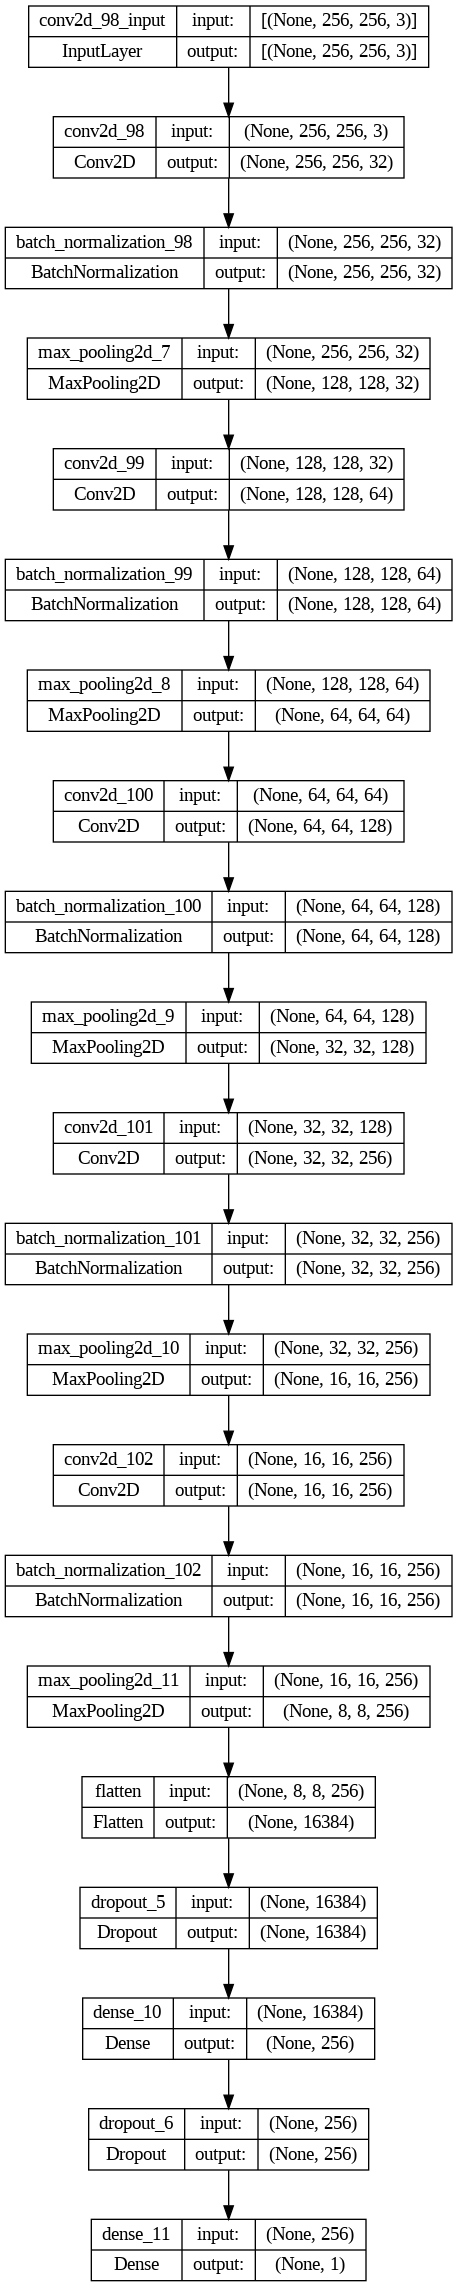

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

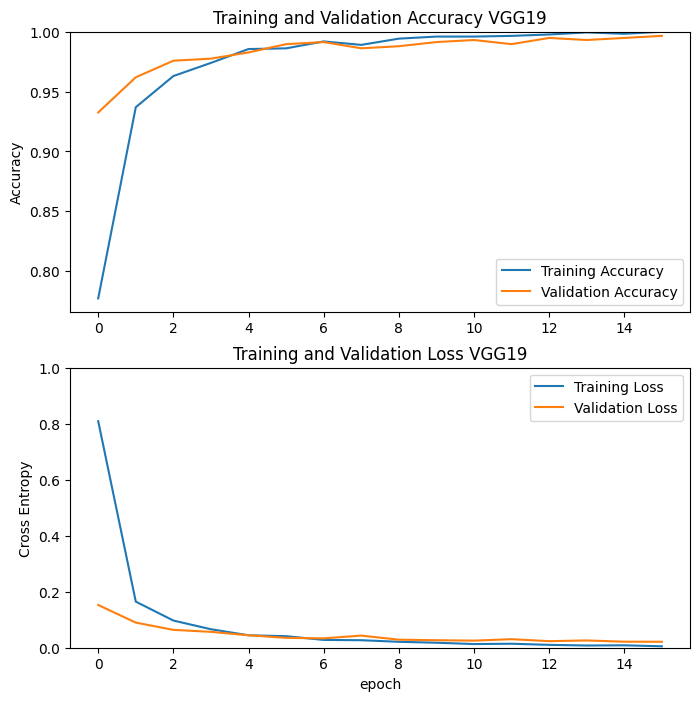

In [ ]:
acc = history_vgg19.history['accuracy']
val_acc = history_vgg19.history['val_accuracy']
loss = history_vgg19.history['loss']
val_loss = history_vgg19.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy VGG19')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss VGG19')
plt.xlabel('epoch')
plt.show()

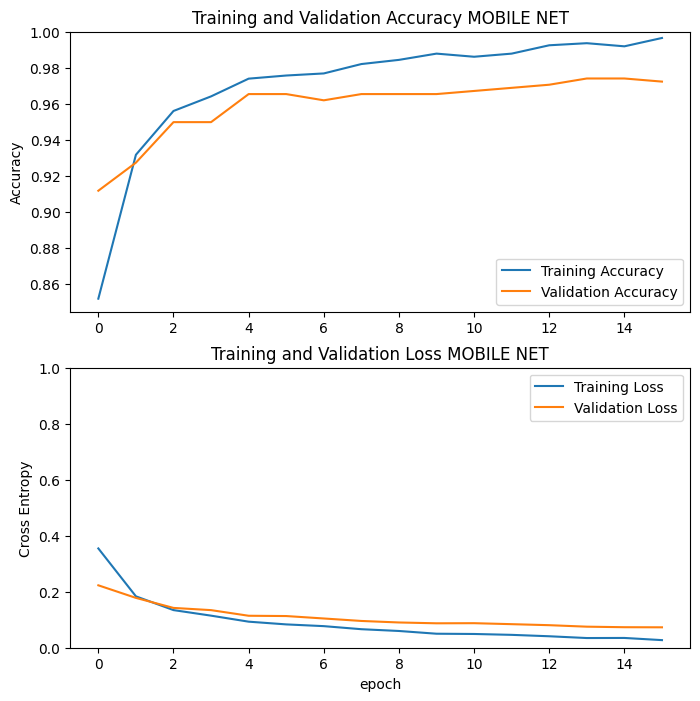

In [ ]:
acc = history_monet.history['accuracy']
val_acc = history_monet.history['val_accuracy']
loss = history_monet.history['loss']
val_loss = history_monet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy MOBILE NET')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss MOBILE NET')
plt.xlabel('epoch')
plt.show()

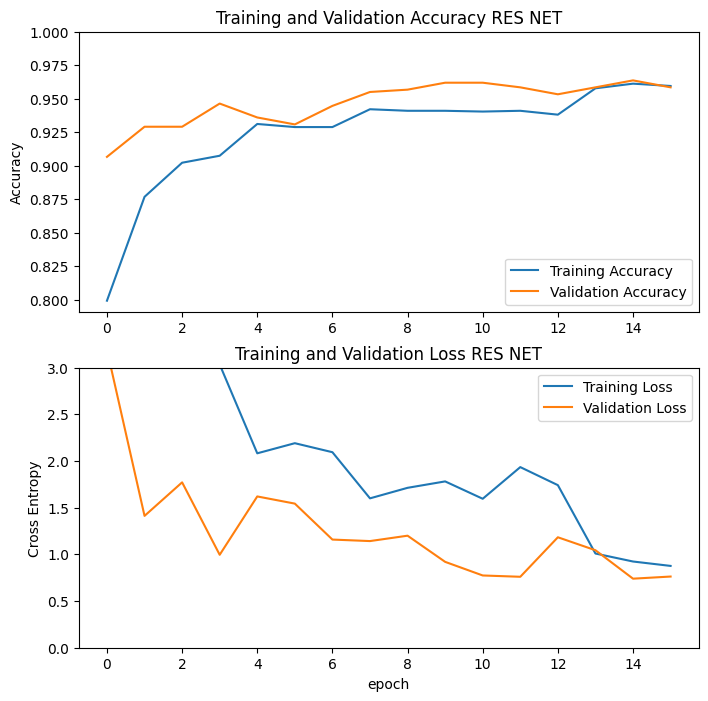

In [ ]:
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy RES NET')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3])
plt.title('Training and Validation Loss RES NET')
plt.xlabel('epoch')
plt.show()

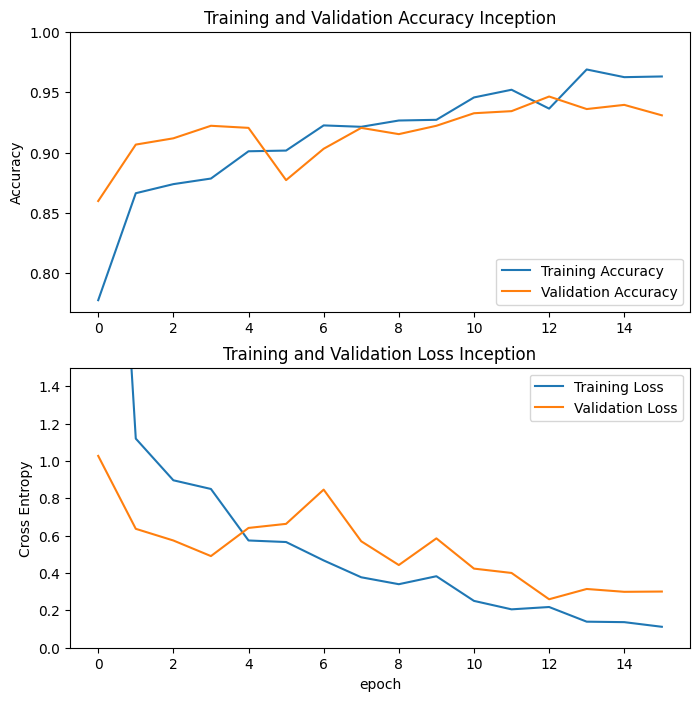

In [ ]:
acc = history_inception.history['accuracy']
val_acc = history_inception.history['val_accuracy']
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy Inception')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss Inception')
plt.xlabel('epoch')
plt.show()

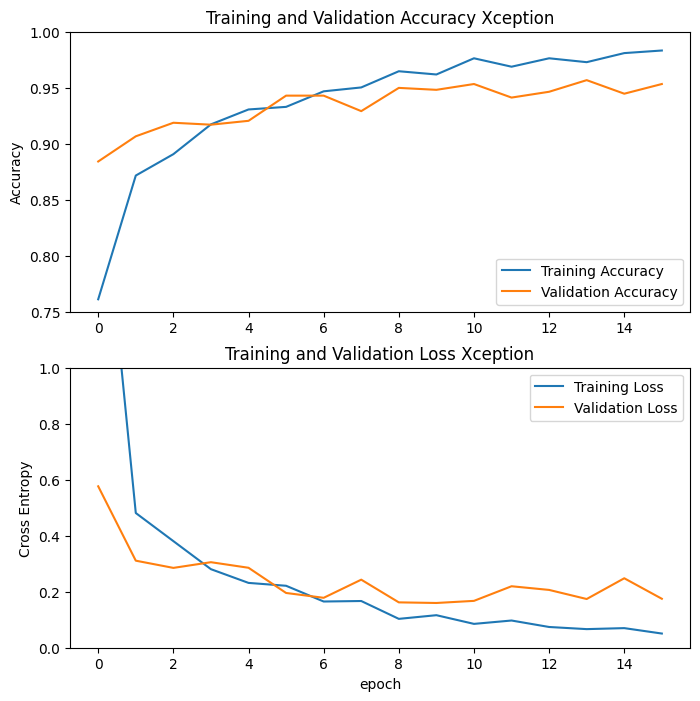

In [ ]:
acc = history_xception.history['accuracy']
val_acc = history_xception.history['val_accuracy']
loss = history_xception.history['loss']
val_loss = history_xception.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy Xception')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss Xception')
plt.xlabel('epoch')
plt.show()

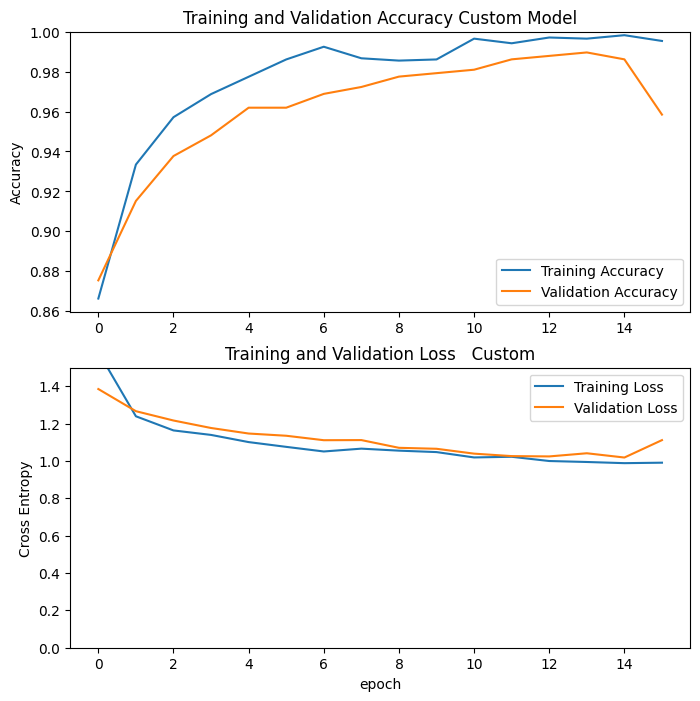

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy Custom Model')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss   Custom')
plt.xlabel('epoch')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#



19/19 [==============================] - 5s 85ms/step - loss: 1.1026 - accuracy: 0.9540
                     Model  Test Loss  Test Accuracy
0                 Xception   0.246035       0.952300
1                    VGG19   0.018983       0.991482
2                 ResNet50   0.913245       0.964225
3                Inception   0.234622       0.933560
4                MoBilenet   0.059156       0.976150
5  Custom TensorFlow Model   1.102625       0.954003


<ipython-input-36-cdc44b40003b>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')


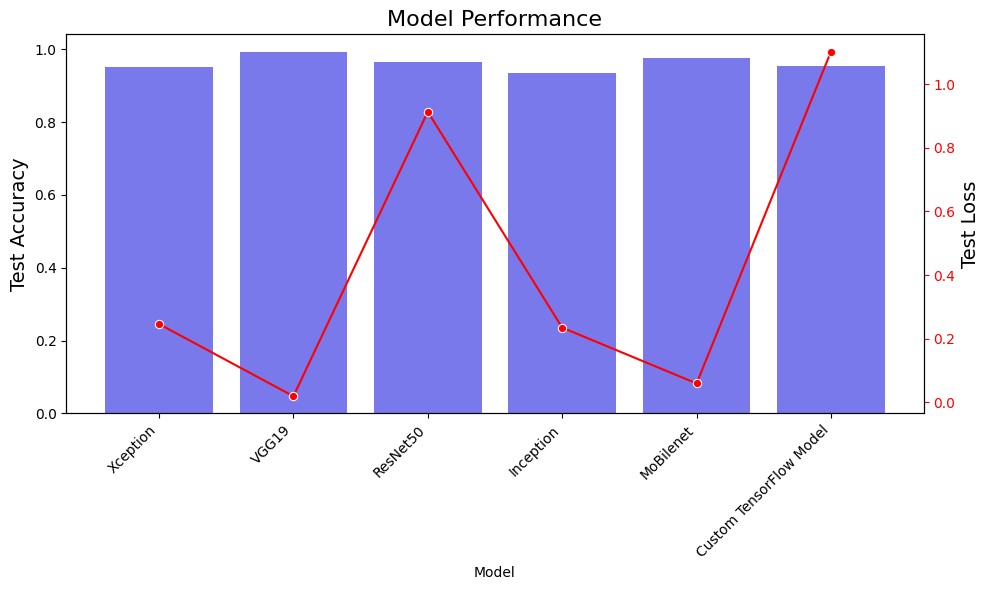

In [ ]:
import pandas as pd

# Assuming model_xception, model_vgg19, etc., and test_dataset are defined
models = {
    'Xception': model_xception,
    'VGG19': model_vgg19,
    'ResNet50': model_resnet,
    'Inception': model_inception,
    'MoBilenet': model_monet,  # corrected model name
    'Custom TensorFlow Model': model
}

results_list = []  # Use a list to collect data

# Evaluate each model and collect results
for model_name, model in models.items():
    test_loss, test_acc = model.evaluate(test_dataset)
    results_list.append({'Model': model_name, 'Test Loss': test_loss, 'Test Accuracy': test_acc})

# Create a DataFrame from the collected data
results_df = pd.DataFrame(results_list, columns=['Model', 'Test Loss', 'Test Accuracy'])

# Display the DataFrame
print(results_df)
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Test Accuracy
ax1.set_title('Model Performance', fontsize=16)
ax1 = sns.barplot(x='Model', y='Test Accuracy', data=results_df, color='blue', alpha=0.6)
ax1.set_ylabel('Test Accuracy', fontsize=14)
ax1.tick_params(axis='y')

# Specify the labels for x-axis
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')

# Line plot for Test Loss with secondary y-axis
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='Model', y='Test Loss', data=results_df, marker='o', color='red', sort=False)
ax2.set_ylabel('Test Loss', fontsize=14)
ax2.tick_params(axis='y', colors='red')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:

results_df

,Model,Test Loss,Test Accuracy
0,Xception,0.246035,0.952300
1,VGG19,0.018983,0.991482
2,ResNet50,0.913245,0.964225
3,Inception,0.234622,0.933560
4,MoBilenet,0.059156,0.976150
5,Custom TensorFlow Model,1.102625,0.954003


In [ ]:
model_vgg19.save('/content/drive/MyDrive/RAIL PROJECT/MODELS/vgg109.h5')

NameError: name 'model_vgg19' is not defined

In [ ]:
model_resnet.save('/content/drive/MyDrive/RAIL PROJECT/MODELS/resnet.h5')

In [ ]:
model_monet.save('/content/drive/MyDrive/RAIL PROJECT/MODELS/mobilenet.h5')


In [ ]:
model_inception.save('/content/drive/MyDrive/RAIL PROJECT/MODELS/inception.h5')

In [ ]:
model_xception.save('/content/drive/MyDrive/RAIL PROJECT/MODELS/xception.h5')

In [ ]:
model.save('/content/drive/MyDrive/RAIL PROJECT/MODELS/custommodel.h5')

In [ ]:
!gdown --id 1RyoJ8Sfa7RtUgsVe71utCqsIK8kh_FJm

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RyoJ8Sfa7RtUgsVe71utCqsIK8kh_FJm
To: /content/vgg109.h5
100% 86.5M/86.5M [00:04<00:00, 17.6MB/s]


In [ ]:
import tensorflow as tf

In [ ]:
from google.colab import drive
import numpy as np
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/vgg109.h5")

In [ ]:
import cv2
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    # Load the image file, resizing it to the input size of our model
    img = image.load_img(img_path, target_size=(256,256))

    # Convert the image to array
    img_array = image.img_to_array(img)

    # Normalize the image pixels
    img_array /= 255.0

    # Expand dimensions to fit the batch size
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [ ]:
import cv2
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    # Load the image file, resizing it to the input size of our model
    img = image.load_img(img_path, target_size=(256,256))

    # Convert the image to array
    img_array = image.img_to_array(img)

    # Normalize the image pixels
    img_array /= 255.0

    # Expand dimensions to fit the batch size
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [ ]:

def predict_image(model, img_path):
    # Preprocess the image
    img_array = load_and_preprocess_image(img_path)

    # Make predictions
    predictions = model.predict(img_array)

    # Decode the predictions to the original labels
    predicted_label = "LEAVES" if predictions[0] > 0 else "Clean"

    return predicted_label

In [ ]:
from google.colab import files
from IPython.display import Image, display, clear_output
import ipywidgets as widgets

In [ ]:
uploader = widgets.FileUpload(
    accept='image/*',  # Accept only image files
    multiple=False  # Do not allow multiple files
)
display(uploader)

FileUpload(value={}, accept='image/*', description='Upload')

In [ ]:
def predict_uploaded_image(model, uploader):
    # Check if the uploader widget contains a file
    if uploader.value:
        # Retrieve the uploaded file
        [uploaded_file] = uploader.value.values()

        # Get the content and the name of the uploaded file
        content = uploaded_file['content']
        name = uploaded_file['metadata']['name']

        # Write the content to a file
        with open(name, 'wb') as f:
            f.write(content)

        # Make predictions
        predicted_label = predict_image(model, name)

        # Display the uploaded image and the prediction result
        display(Image(name))
        print(f"The model predicts that the image is a {predicted_label} Rail")

        # Clear the uploader for the next upload
        uploader.value.clear()
        uploader._counter = 0

In [ ]:
button = widgets.Button(description="Predict")
output = widgets.Output()

# Define the button click event
def on_button_clicked(b):
    with output:
        # Clear the previous output
        clear_output(wait=True)

        # Predict the uploaded image
        predict_uploaded_image(model, uploader)

# Set the button click event
button.on_click(on_button_clicked)

# Display button and output
display(button, output)

Button(description='Predict', style=ButtonStyle())

Output()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
